#Data Quality Report 
#Coastal Pioneer, Offshore Profiler Mooring (CTD)



**Evaluator: Amin Ilia**  
amin.ilia@gmail.com 

**Evaluation Date**: 5/25/2018


## 1. *Selected* instruments
In this report, I will evaluate the CTD (specifically temperature and salinity) from the Pioneer Offshore Profiler Mooring (CP04OSPM), focusing on the 2015 year (Deployment 2, 3, and 4).

###note: 
Due to stucking the wire durring two periods in 2015, I finally used  data for the peiod of 2015-10-13 to 2016-06-02, development 4 and 5 (see section 6)

I will use shiboard CTD data, Pioneer-06 2015-05-12 to validate profiler data.

In [0]:
# Setup Instrument Variables
site = 'CP04OSPM'        # CP04OSPM-WFP01-03-CTDPFK000
node = 'WFP01'
instrument = '03-CTDPFK000'
method = 'recovered_wfp'
stream = 'ctdpf_ckl_wfp_instrument_recovered'



##2. Time periods of interest
I will focus on the following time periods for evaluation:

Jan 1, 2015 to Jan 01, 2016 - Deployment 2, 3, and 4 (see step 4)


Oct 13, 2015 to June 02, 2016 (see step 6)


In [0]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd


In [0]:
import matplotlib.pyplot as plt

!pip install xarray
!pip install dask
import xarray as xr

!pip install cmocean
import cmocean

!pip install netCDF4
import netCDF4 as nc

import re
import os


/usr/local/lib/python3.6/dist-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


## 3. Related Metadata
In this section, I will review some of metadata available in the system to make sure it is present and correct.

In [0]:
# API Information
USERNAME =''
TOKEN= ''
DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'


In [0]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None

### 3a. Vocabulary Metadata
Grab the basic vocabulary information (metadata) from the system to make sure we have the right instrument.

In [0]:
# Setup the API request url
data_request_url ='/'.join((VOCAB_API,site,node,instrument))
print(data_request_url)

# Grab the information from the server
r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
data = r.json()
data

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/CP04OSPM/WFP01/03-CTDPFK000


[{'@class': '.VocabRecord',
  'instrument': 'CTD',
  'manufacturer': 'Sea-Bird',
  'maxdepth': 427.0,
  'mindepth': 15.0,
  'model': 'SBE 52MP',
  'refdes': 'CP04OSPM-WFP01-03-CTDPFK000',
  'tocL1': 'Coastal Pioneer',
  'tocL2': 'Offshore Profiler Mooring',
  'tocL3': 'Wire-Following Profiler',
  'vocabId': 613}]

### 3b. Deployment Information
Grab some information about the deployments for this instrument. I will grab all of the deployments available in the system for 2015 to 2017. Then I output the date ranges, latitude/longitude, asset ID, and sensor ID for each.  Note that the **reference designator** specified above represents the geographical location of an instrument across all deployments (e.g. the CTD on the Pioneer Upstream Offshore Profiler), the **Sensor ID** (and its Asset ID equivalent) represent the specific instrument used for a given deployment (i.e. a unique make, model, and serial numbered instrument).

In [0]:
# Setup the API request url
data_request_url = ASSET_API + '/events/deployment/query'
params = {
  'beginDT':'2015-01-01T00:00:00.000Z',
  'endDT':'2017-01-01T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+instrument,   
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,1677.0,2.0,39.94152,-70.87843,CGINS-CTDPFK-00106,2014-10-04 20:04:00,2015-04-29 00:00:00
1,1641.0,3.0,39.94303,-70.88537,CGINS-CTDPFK-00126,2015-04-29 20:15:00,2015-10-12 12:44:00
2,1677.0,4.0,39.93565,-70.87998,CGINS-CTDPFK-00106,2015-10-12 19:11:00,2016-05-19 12:09:00
3,1641.0,5.0,39.94325,-70.88667,CGINS-CTDPFK-00126,2016-05-19 22:35:00,2016-09-28 13:25:00
4,1642.0,6.0,39.93647,-70.88022,CGINS-CTDPFK-00124,2016-10-01 14:19:00,2017-06-01 23:22:00


### 3c. Calibration Information


In [0]:
# Setup the API request url
data_request_url = ASSET_API + '/asset/cal'
params = {
  'beginDT':'2015-01-01T00:00:00.000Z',
  'endDT':'2016-01-01T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+'04-FLORTK000',
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Reformat the data into a pretty table
df = pd.DataFrame() # Setup empty array
for d in data:
  for dd in d['sensor']['calibration']:
    for ddd in dd['calData']:
      df = df.append({
        'value': ddd['value'],
        'start': convert_time(ddd['eventStartTime']),
        'stop': convert_time(ddd['eventStopTime']),
        'name': ddd['eventName'],
        'assetUid': ddd['assetUid'],
        }, ignore_index=True)
    
df = df.sort_values(by=['start','name'])
df


,assetUid,name,start,stop,value
23,CGINS-FLORTK-01118,CC_angular_resolution,2013-09-27,None,1.076000
31,CGINS-FLORTK-01118,CC_dark_counts_cdom,2013-09-27,None,57.000000
33,CGINS-FLORTK-01118,CC_dark_counts_chlorophyll_a,2013-09-27,None,51.000000
44,CGINS-FLORTK-01118,CC_dark_counts_volume_scatter,2013-09-27,None,49.000000
41,CGINS-FLORTK-01118,CC_depolarization_ratio,2013-09-27,None,0.039000
27,CGINS-FLORTK-01118,CC_measurement_wavelength,2013-09-27,None,700.000000
48,CGINS-FLORTK-01118,CC_scale_factor_cdom,2013-09-27,None,0.094800
39,CGINS-FLORTK-01118,CC_scale_factor_chlorophyll_a,2013-09-27,None,0.012500
22,CGINS-FLORTK-01118,CC_scale_factor_volume_scatter,2013-09-27,None,0.000003
35,CGINS-FLORTK-01118,CC_scattering_angle,2013-09-27,None,124.000000


### 3d. Annotations
Finally, let's pull any relevant annotations for the CTD instrument since 2015 to 2018.

In [0]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT':int(datetime.date(2015,1,1).strftime('%s'))*1000,
  'endDT':int(datetime.date(2018,1,1).strftime('%s'))*1000,
  'refdes':site+'-'+node+'-'+instrument,
}

r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,Failed,354.0,None,None,CP04OSPM,2016-10-12 06:00:02,2017-06-01 23:22:00
1,Wire Following Profiler is stuck at the top of its range.,613.0,WFP01,None,CP04OSPM,2016-06-02 15:00:00,2016-09-28 13:25:00


The wire stuck at top of its range after 2016-06-02 so We would use 2015.

## 4. The full dataset
Now let's take a look at a large range of data.  We shall look at all of Deployment 2, 3, and 4.  First we need to add some additional libraries to our Python environment.

In [0]:

beginDT = '2015-01-01T01:01:01.500Z' 
endDT = '2016-01-01T01:01:01.500Z'

data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [0]:
data['allURLs'][0]

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/amin.ilia@gmail.com/20180523T192057-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/catalog.html'

In [0]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 9 ms, sys: 4 ms, total: 13 ms
Wall time: 341 ms


In [0]:
# Get data urls

url = data['allURLs'][0]
tdata_url_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/amin.ilia@gmail.com/20180523T192057-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0004_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20151012T220003-20160101T002638.994968.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/amin.ilia@gmail.com/20180523T192057-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0003_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20150429T220003-20151012T121234.987920.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/amin.ilia@gmail.com/20180523T192057-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0002_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20150101T030002-20150428T211309.988461.nc']

In [0]:
# load all data into a single array
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})    # swap dimension to time
ds = ds.chunk({'time': 100})
ds = ds.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.
ds

<xarray.Dataset>
Dimensions:                                      (time: 2529906)
Coordinates:
    obs                                          (time) int64 0 1 2 3 4 5 6 ...
  * time                                         (time) datetime64[ns] 2015-01-01T03:00:02 ...
    pressure                                     (time) float64 6.702e+03 ...
    lat                                          (time) float64 39.94 39.94 ...
    lon                                          (time) float64 -70.88 ...
Data variables:
    deployment                                   (time) int32 2 2 2 2 2 2 2 ...
    id                                           (time) |S64 b'c2b551d6-51d5-4c27-a71c-33acabeb05f5' ...
    conductivity                                 (time) float64 4.399e+05 ...
    driver_timestamp                             (time) datetime64[ns] 2017-09-26T15:42:34.203197952 ...
    ingestion_timestamp                          (time) datetime64[ns] 2017-09-26T15:42:34.463000064 ...
    inte

## 5. Checking the data 

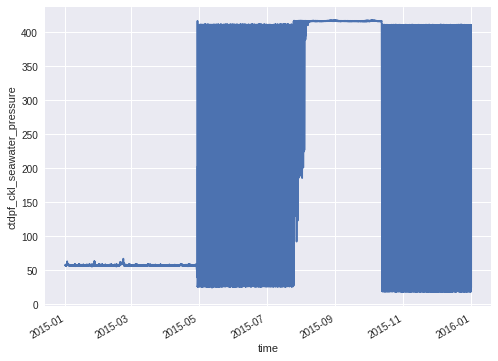

In [0]:
# Check pressure data
ds['ctdpf_ckl_seawater_pressure'].plot();

Pressure data is not good.

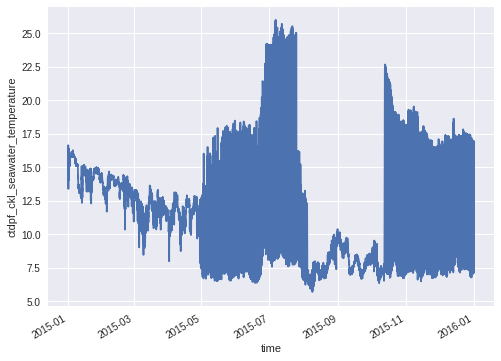

In [0]:
# Check temperature data
ds['ctdpf_ckl_seawater_temperature'].plot();

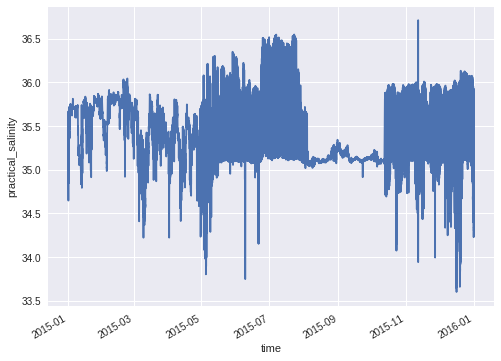

In [0]:
# Check salinity data
ds['practical_salinity'].plot();

###note: 
It seems that the profiler stuck at botom before 2015-04-28 and gradually stuck at botom after 2015-07-20 and completly stucks at botom between 2015-08-05 and  2015-10-12. There isn't any annotation for these periods and I would report these to be added in annotation. 

## 6. Changing focusing time period



###Now I'm looking at the data since 2015-10-13 to 2016-06-02
Full deployment 4 and part of developement 5

In [0]:

beginDT = '2015-10-13T01:01:01.500Z' 
endDT = '2016-06-02T01:01:01.500Z'

data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [0]:
data['allURLs'][0]

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/amin.ilia@gmail.com/20180524T140054-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/catalog.html'

In [0]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 10 ms, sys: 2 ms, total: 12 ms
Wall time: 450 ms


In [0]:
# Get data urls

url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/amin.ilia@gmail.com/20180524T140054-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0005_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20160520T000003-20160602T002939.994915.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/amin.ilia@gmail.com/20180524T140054-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0004_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20151013T030002-20160519T093808.996051.nc']

In [0]:
# to aviod request data from database repeatedly 
datasets = ['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/amin.ilia@gmail.com/20180524T140054-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0005_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20160520T000003-20160602T002939.994915.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/amin.ilia@gmail.com/20180524T140054-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0004_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20151013T030002-20160519T093808.996051.nc'];

# load all data into a single array
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})    # swap dimension to time
ds = ds.chunk({'time': 100})
ds = ds.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.
ds

<xarray.Dataset>
Dimensions:                                      (time: 2476366)
Coordinates:
    obs                                          (time) int64 dask.array<shape=(2476366,), chunksize=(2476366,)>
  * time                                         (time) datetime64[ns] 2015-10-13T03:00:02 ...
    pressure                                     (time) float64 dask.array<shape=(2476366,), chunksize=(2476366,)>
    lat                                          (time) float64 dask.array<shape=(2476366,), chunksize=(2476366,)>
    lon                                          (time) float64 dask.array<shape=(2476366,), chunksize=(2476366,)>
Data variables:
    deployment                                   (time) int32 dask.array<shape=(2476366,), chunksize=(2476366,)>
    id                                           (time) |S64 dask.array<shape=(2476366,), chunksize=(2476366,)>
    conductivity                                 (time) float64 dask.array<shape=(2476366,), chunksize=(2476366

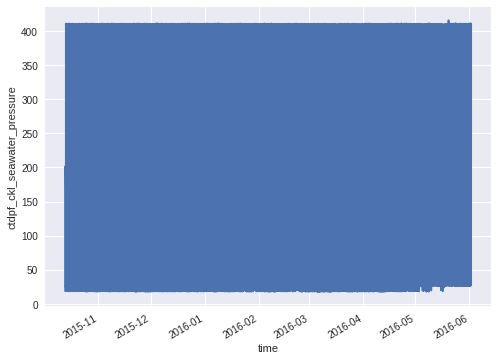

In [0]:
# Check pressure data
ds['ctdpf_ckl_seawater_pressure'].plot();

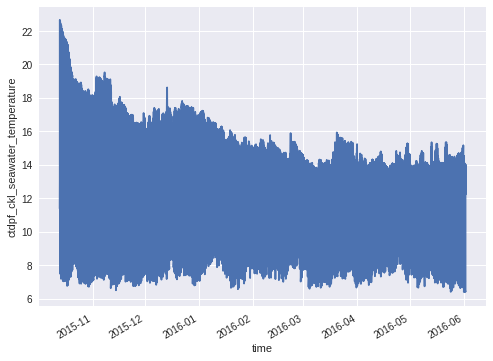

In [0]:
# Check temperature data
ds['ctdpf_ckl_seawater_temperature'].plot();

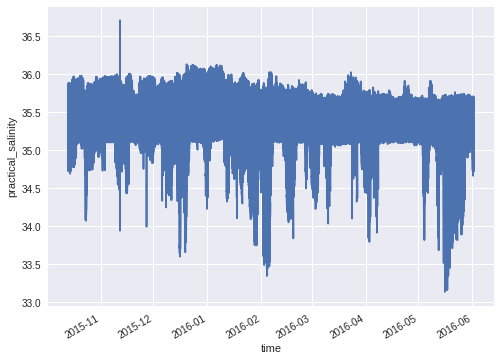

In [0]:
# Check salinity data
ds['practical_salinity'].plot();

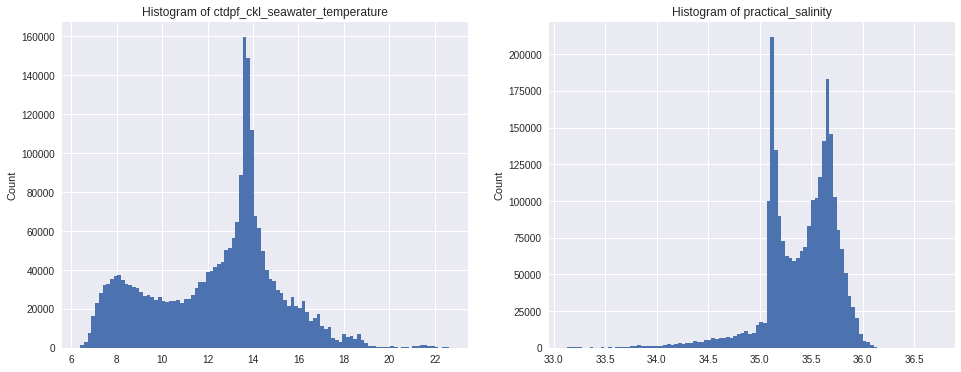

In [0]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ds['ctdpf_ckl_seawater_temperature'].plot.hist(bins=100, ax=ax1)
ds['practical_salinity'].plot.hist(bins=100, ax=ax2);

In [0]:
dtime = ds['time'].values
pressure = ds['ctdpf_ckl_seawater_pressure'].values
temperature = ds['ctdpf_ckl_seawater_temperature'].values
salinity = ds['practical_salinity'].values

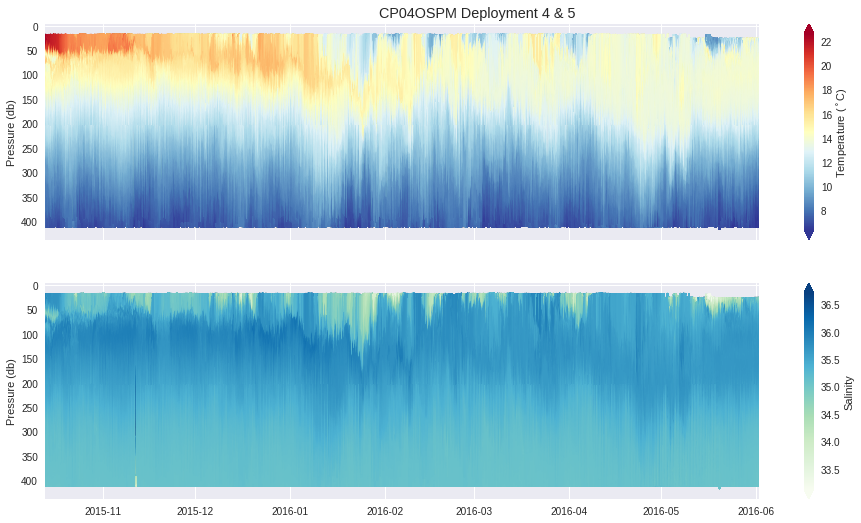

In [0]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,8))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (db)')
ax2.set_ylabel('Pressure (db)')

fig.suptitle(' Deployment 4 & 5')
fig.subplots_adjust(top=0.95);


At October, there are high temprature gradiant in water profile. The water surface cooled and the mixed layer deepen after January. Temperature data seem to be reasonable. Track of fresh water from MAB can be seen at the surface from Salinity profile.


## 7. Checking with satellite data

* Surface temperature agreas with SST sattelite in October, although profiler just collect 10m depth data
![SST for Oct 22, 2015](https://marine.rutgers.edu/cool/regions/bigbight/sst_comp/noaa/2015/img/151022.295.comp.lnt.jpg)




* Surface temperature agreas with SST sattelite in May, although profiler just collect 7m depth data



![alt text](https://marine.rutgers.edu/cool/regions/bigbight/sst_comp/noaa/2016/img/160509.130.comp.lnt.jpg)

## 8. Plotting monthly profiles


In [0]:
ds1 = ds.loc[dict(time=slice('2015-10-01','2015-11-01'))]
a=ds1['practical_salinity'].values
b=ds1['ctdpf_ckl_seawater_temperature'].values
cc=ds1['ctdpf_ckl_seawater_pressure'].values

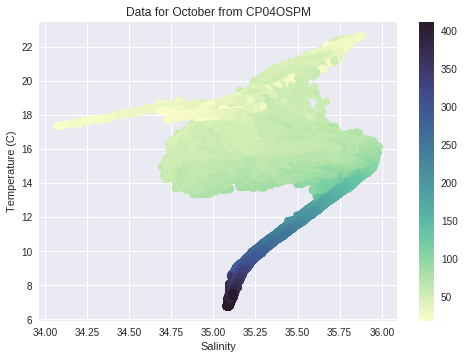

In [0]:
sc = plt.scatter(a, b, c = cc, cmap=cmocean.cm.deep)
plt.colorbar(sc)    
plt.xlabel('Salinity')
plt.ylabel('Temperature (C)')
plt.title('Data for October 2015 from %s' % site);

In [0]:
ds1 = ds.loc[dict(time=slice('2015-11-01','2015-12-01'))]
a=ds1['practical_salinity'].values
b=ds1['ctdpf_ckl_seawater_temperature'].values
cc=ds1['ctdpf_ckl_seawater_pressure'].values

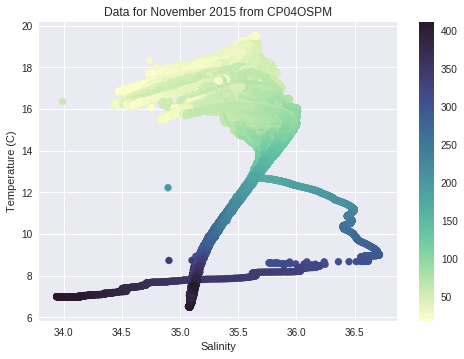

In [0]:
sc = plt.scatter(a, b, c = cc, cmap=cmocean.cm.deep)
plt.colorbar(sc)    
plt.xlabel('Salinity')
plt.ylabel('Temperature (C)')
plt.title('Data for November 2015 from %s' % site);

On November, it seems there was a problem for one of the diving of profiler. While the temperature data seems to be reasonable salinity data are not reasonable. 

In [0]:
ds1 = ds.loc[dict(time=slice('2015-12-01','2016-01-01'))]
a=ds1['practical_salinity'].values
b=ds1['ctdpf_ckl_seawater_temperature'].values
cc=ds1['ctdpf_ckl_seawater_pressure'].values

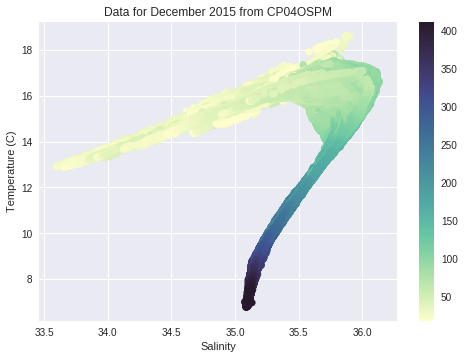

In [0]:
sc = plt.scatter(a, b, c = cc, cmap=cmocean.cm.deep)
plt.colorbar(sc)    
plt.xlabel('Salinity')
plt.ylabel('Temperature (C)')
plt.title('Data for December 2015 from %s' % site);

In [0]:
ds2 = ds.loc[dict(time=slice('2016-02-01','2016-03-01'))]
a=ds2['practical_salinity'].values
b=ds2['ctdpf_ckl_seawater_temperature'].values
cc=ds2['ctdpf_ckl_seawater_pressure'].values

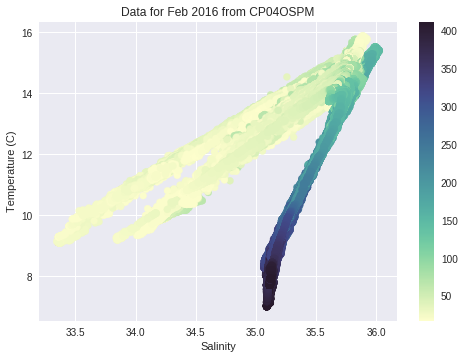

In [0]:
sc = plt.scatter(a, b, c = cc, cmap=cmocean.cm.deep)
plt.colorbar(sc)    
plt.xlabel('Salinity')
plt.ylabel('Temperature (C)')
plt.title('Data for Feb 2016 from %s' % site);

In [0]:
ds3 = ds.loc[dict(time=slice('2016-05-01','2016-06-01'))]
a=ds3['practical_salinity'].values
b=ds3['ctdpf_ckl_seawater_temperature'].values
cc=ds3['ctdpf_ckl_seawater_pressure'].values

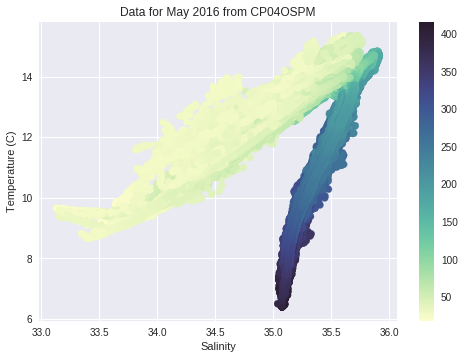

In [0]:
sc = plt.scatter(a, b, c = cc, cmap=cmocean.cm.deep)
plt.colorbar(sc)    
plt.xlabel('Salinity')
plt.ylabel('Temperature (C)')
plt.title('Data for May 2016 from %s' % site);

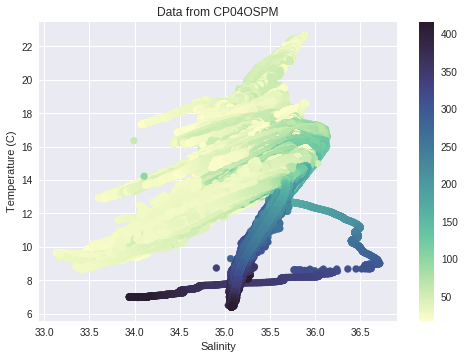

In [0]:
# Plot total data profiles
sc = plt.scatter(salinity, temperature, 
            c = pressure, cmap=cmocean.cm.deep)
plt.colorbar(sc)    
plt.xlabel('Salinity')
plt.ylabel('Temperature (C)')
plt.title('Data from %s' % site);

## 9. Checking problem in Salinity in November 2015
Plot data for the period of Nomber 10 to 15 to see what happen to salinity

In [0]:
ds1=ds.loc[dict(time=slice('2015-11-10','2015-11-15'))]
dtime1 = ds1['time'].values
salinity1 = ds1['practical_salinity'].values
temperature1 = ds1['ctdpf_ckl_seawater_temperature'].values
pressure1 = ds1['ctdpf_ckl_seawater_pressure'].values

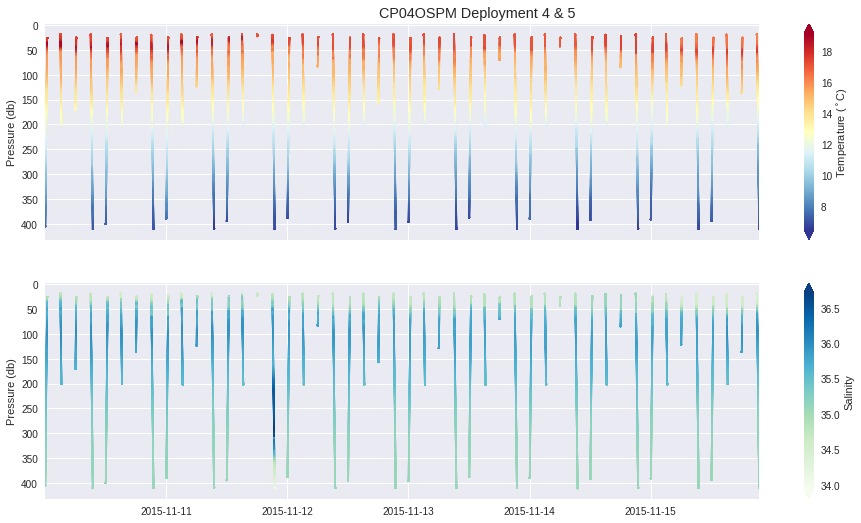

In [0]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,8))
sc1 = ax1.scatter(dtime1, pressure1, c=temperature1, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(dtime1, pressure1, c=salinity1, cmap='GnBu', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime1[0],dtime1[-1]) # Set the time limits to match the dataset
# ax1.set_xlim([datetime.date(2015,11,1), datetime.date(2015,11,20)]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (db)')
ax2.set_ylabel('Pressure (db)')

fig.suptitle('CP04OSPM Deployment 4 & 5')
fig.subplots_adjust(top=0.95);

## 10. Comparing with Cruise CTD data
For cruise data, I used the data collected during the Pioneer 6 Cruise, Leg 1, Cast #02, which occurred on 2016-05-12 UTC.

In [0]:
# Down and Up Casts
cruise_data_file = 'https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/f774f6ed-4a34-4943-8445-f3884c67d234/ar04a002.asc'

# Read in the data file without headers due to a bug in the file (two of the header names run together)
cruise_data = pd.read_table(cruise_data_file, delim_whitespace=True, header=None, skiprows=1)

# Add back the necessary headers
cruise_data = cruise_data.rename(columns={0:'Pressure', 1:'Temperature', 10:'Salinity'})


In [0]:
cruise_data.head()

,Pressure,Temperature,2,3,4,5,6,7,8,9,10,11,12,Salinity,14,15,16,17,18
0,6.046,13.5630,13.5637,4.067267,4.066925,3.8433,1.2732,1.0676,0.6841,84.2803,34.2058,-9135.0,1.25730,6.0,34.2085,34.2046,1501.21,7.1059,0.0
1,7.054,13.6780,13.6846,4.094196,4.094327,3.8334,1.1675,1.0590,0.6902,84.1509,34.3434,-9135.0,0.98563,7.0,34.3573,34.3527,1501.78,7.0619,0.0
2,8.062,13.9065,13.9233,4.136020,4.136064,3.8247,1.2768,1.0782,0.7067,83.8054,34.5135,-9135.0,0.72330,8.0,34.5425,34.5278,1502.76,7.0030,0.0
3,9.070,14.1293,14.1266,4.171771,4.170807,3.8024,1.1779,1.0533,0.7103,83.7299,34.6551,-9135.0,0.53295,9.0,34.6744,34.6679,1503.66,6.9186,0.0
4,10.077,14.1866,14.1882,4.185993,4.186016,3.7818,1.0853,1.0489,0.7156,83.6198,34.7423,-9135.0,0.36472,10.0,34.7544,34.7532,1503.95,6.8637,0.0


In [0]:
# Next let's grab the Profiler data using a synchronous request 
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2016-05-12T00:00:00.000Z',
  'endDT':'2016-05-13T00:00:00.000Z',
  'limit':1000,
}

# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()


In [0]:
# Process the returned JSON dataset into something we can work with
p_time = []
p_temp = []
p_sal = []
p_pr = []
for i in range(len(data)):
  p_time.append(ntp_seconds_to_datetime(data[i]['time']))
  p_temp.append(data[i]['ctdpf_ckl_seawater_temperature'])
  p_sal.append(data[i]['practical_salinity'])
  p_pr.append(data[i]['ctdpf_ckl_seawater_pressure'])


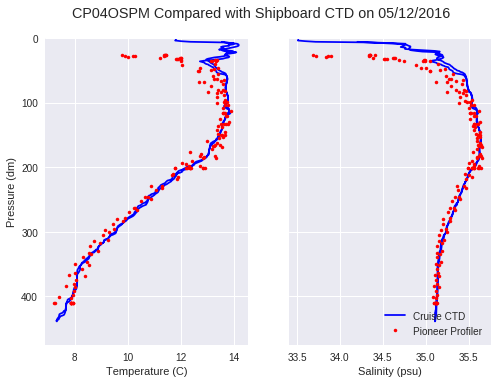

In [0]:
# Now let's plot the Cruise and Profiler data together
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(cruise_data.Temperature,cruise_data.Pressure,'b')
ax1.plot(p_temp,p_pr,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')
# ax1.invert_yaxis()
ax1.set_ylim(475,0)

ax2.plot(cruise_data.Salinity,cruise_data.Pressure,'b',label='Cruise CTD')
ax2.plot(p_sal,p_pr,'r.',label='Pioneer Profiler')
ax2.set_xlabel('Salinity (psu)')

fig.suptitle('CP04OSPM Compared with Shipboard CTD on 05/12/2016')
fig.subplots_adjust(top=0.9)

legend = ax2.legend(loc='lower right', shadow=True, fontsize='small');


In general, the data from the CTD cast aligns nicely with the profiler data from the same day.  Interestingly, the up and down casts from the shipboard CTD match very well, which often isn't the case.  The profiler matches in general terms with the ship, but there is a bit of variability around the profile Specially near the surface water. 

## 11. Conclusion


Based on this analysis of the Coastal Pioneer, Offshore Profiler Mooring, I note the following takeaways:
* The profiler was inoperative during the end of Deployments 2, 3, and 5; however the CTD data still appears reasonable. 
* For Deployment 2 the profiler stuck at top (depth 55m) before 2015-04-28. For Deployment 3, after 2015-07-20, the profiler gradually stuck at bottom and then between 2015-08-05 and 2015-10-12 completely stuck at bottom (depth 420m). There isn't any annotation about it in the system therefore the annotation concerning these should be added in the system. 

* Temperature and salinity variability for the period of October 13, 2015 to June 02, 2016 were plotted.
* In general, the temperature, salinity and pressure values during deployment 4 and the beginning of deployment 5 (until 2016-06-02) look largely reasonable. There are no major outliers.
* The data seems to align with known physical processes, there is shallow mixed layer in the fall, but the mixed layer is deepened during winter and temperature profile is became uniform
* The cruise CTD data for the May 12, 2016 were compared with profiler data. The data generally have good agreement.

* On November 11 in 2015, the profiler observed some high and unusual salinity while diving. However temperature data are quite reseanable. It can be due to a small problem in conductivity sensor. 

* Accessing OOI data using Python can be fun and I really enjoyed the OOI Physics workshop.
